# ANALISIS ANGGARAN PEMASARAN
Pada analisis kali ini, bertujuan untuk mengoptimalkan anggaran biaya pemasaran di perusahaan Y.Afisha. Analisis ini menggunakan data log atau catatan server yang memuat data kunjungan ke situs web Y.Afisha dari bulan Juni 2017 hingga bulan Mei 2018, data pesanan, dan data pengeluaran. Kali ini metrik-metrik yang menjadi perhatian yaitu:
- Bagaimana para pengguna menggunakan produk Y.Afisha
- Kapan mereka mulai melakukan pembelian
- Berapa jumlah uang yang disumbangkan oleh setiap pengguna
- Kapan semua biaya pemasaran terbayarkan

## Memuat Dataset dan Library
Di tahap ini akan dilakukan pengunduhan dataset dan library yang dibutuhkan. Dataset yang digunakan ada 3 yaitu dataset visits, orders, dan costs. Sebelum menyimpan datasetnya, perlu dilakukan pengambilan sampel mengenai data tersebut, untuk mengoptimalkan dataset sehingga nantinya proses analisis dapat berjalan dengan baik.

In [1]:
# import library yang dibutuhkan
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats as st
from datetime import timedelta
from statistics import mode

from datetime import timedelta, datetime
from dateutil.relativedelta import relativedelta

In [2]:
# Mengambil 500 sampel data
try:
    visit_samp = pd.read_csv(
        r'C:\Users\Adam\OneDrive\Course\TripleTen\Sprint 7\visits_log_us.csv', nrows=500
    )
    
except:
    visit_samp = pd.read_csv(
        '/datasets/visits_log_us.csv', nrows=500
    )

In [3]:
# Menampilkan informasi umum sampel data
visit_samp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Device     500 non-null    object
 1   End Ts     500 non-null    object
 2   Source Id  500 non-null    int64 
 3   Start Ts   500 non-null    object
 4   Uid        500 non-null    uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 19.7+ KB


In [4]:
# Memeriksa nilai device pada sampel
visit_samp['Device'].value_counts()

desktop    363
touch      137
Name: Device, dtype: int64

Dari dataset visit ini terdapat kolom tanggal dan kolom kategori. Akan tetapi nama-nama dari kolom dataset di atas tertulis dengan huruf kapital. Untuk itu, tipe data pada ketiga dataset ini akan disesuaikan terlebih dahulu pada awal pengunduhan supaya pemrosesan data berjalan optimal yaitu merubah tipe data yang memuat waktu dan tanggal menjadi datetime dan untuk kategori, tipe datanya akan diganti menjadi category. Untuk nama-nama kolomnya, akan diubah langsung disini menjadi yang diinginkan.

In [5]:
# memuat dataset visits
try:
    visits = pd.read_csv(
        r'C:\Users\Adam\OneDrive\Course\TripleTen\Sprint 7\visits_log_us.csv', 
    dtype={'Device': 'category'},
    parse_dates=['Start Ts', 'End Ts'],
    ).rename(
        columns={
            'Device' : 'device',
            'End Ts' : 'end_ts',
            'Source Id' : 'source_id',
            'Start Ts' : 'start_ts',
            'Uid' : 'user_id'
        }
    )
except:
    visits = pd.read_csv(
        '/datasets/visits_log_us.csv', 
    dtype={'Device': 'category'},
    parse_dates=['Start Ts', 'End Ts'],
    ).rename(
        columns={
            'Device' : 'device',
            'End Ts' : 'end_ts',
            'Source Id' : 'source_id',
            'Start Ts' : 'start_ts',
            'Uid' : 'user_id'
        }
    )

# memuat dataset orders
try:
    orders = pd.read_csv(
        r'C:\Users\Adam\OneDrive\Course\TripleTen\Sprint 7\orders_log_us.csv',
    parse_dates=['Buy Ts']
    ).rename(
        columns={
            'Uid' : 'user_id',
            'Buy Ts' : 'order_ts',
            'Revenue' : 'revenue'
        }
)
except:
    orders = pd.read_csv(
        '/datasets/orders_log_us.csv', nrows=500,
    parse_dates=['Buy Ts']
    ).rename(
        columns={
            'Uid' : 'user_id',
            'Buy Ts' : 'order_ts',
            'Revenue' : 'revenue'
        }
)

# memuat dataset costs
try:
    costs = pd.read_csv(
    r'C:\Users\Adam\OneDrive\Course\TripleTen\Sprint 7\costs_us.csv',
    parse_dates=['dt']
    ).rename(
        columns={
            'dt' : 'date'
        }
    ) 
except:
    costs = pd.read_csv(
    '/datasets/costs_us.csv',
    parse_dates=['dt']
    ).rename(
        columns={
            'dt' : 'date'
        }
    ) 

In [6]:
# Melihat informasi umum dataset visits
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  category      
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   user_id    359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


In [7]:
# Melihat 10 baris sampel dataset visits
visits.sample(10)

,device,end_ts,source_id,start_ts,user_id
58147,desktop,2018-02-06 19:18:00,3,2018-02-06 19:10:00,13241190571928658191
115338,desktop,2017-06-26 12:01:00,5,2017-06-26 11:44:00,13772651515467648813
198119,desktop,2017-11-25 21:29:00,4,2017-11-25 21:21:00,8690678300937282328
353790,desktop,2017-12-26 22:29:00,2,2017-12-26 22:27:00,1604251243265634858
169745,desktop,2017-12-21 15:35:00,4,2017-12-21 15:09:00,6226946134748265259
272335,desktop,2017-09-11 11:16:00,4,2017-09-11 10:56:00,8638047350729329002
205360,desktop,2017-07-06 19:48:00,2,2017-07-06 17:58:00,13627035067756681808
180983,touch,2017-12-03 15:56:00,2,2017-12-03 15:32:00,5160954362355978074
174112,touch,2018-05-20 18:53:00,3,2018-05-20 18:50:00,6329886215652776406
330051,desktop,2017-11-30 16:58:00,4,2017-11-30 16:51:00,18026396949146799333


Dataset visits memuat data log atau catatan server yang berisikan informasi kunjungan ke situs web. Dataset ini memuat 5 kolom dan informasi sebagai berikut:
- Uid — ID pengguna
- Device — perangkat pengguna
- Start Ts — tanggal dan waktu dimulainya sesi
- End Ts — tanggal dan waktu berakhirnya sesi
- Source Id — ID sumber iklan, sumber yang digunakan pengguna untuk datang ke situs web

Terdiri dari 359400 baris tanpa nilai yang hilang dan untuk format tanggal dalam tabel ini menggunakan format YYYY-MM-DD. Tipe data pada dataset ini sudah disesuaikan semenjak pengunduhan dataset. Untuk nama kolom masih menggunakan huruf kapital sehingga harus diubah menjadi huruf kecil supaya tidak mengganggu proses analisis.

In [8]:
# Melihat informasi umum dataset orders
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   order_ts  50415 non-null  datetime64[ns]
 1   revenue   50415 non-null  float64       
 2   user_id   50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [9]:
# Menampilkan 10 sampel dataset orders
orders.sample(10)

,order_ts,revenue,user_id
36460,2018-02-22 18:20:00,3.67,3275149411973340920
49140,2018-05-27 11:50:00,11.00,12357375853702970338
9981,2017-10-01 17:18:00,3.05,14463734194200231804
16950,2017-11-10 18:51:00,15.89,17893799239256854880
16293,2017-11-05 23:12:00,8.89,14188998187723062716
4403,2017-07-25 20:01:00,4.28,4455206831685794971
4431,2017-07-26 14:17:00,0.49,15075347531750800237
45919,2018-04-28 22:25:00,2.57,17296240946056595832
48460,2018-05-22 14:21:00,4.28,3501596628378158474
22587,2017-12-07 16:18:00,3.67,16862679376244539336


Dataset orders memuat data pesanan. Dataset ini memiliki 50415 baris tanpa nilai yang hilang dengan 3 kolom dan berisikan informasi sebagai berikut: 
- Uid — ID pengguna yang membuat pesanan 
- Buy Ts — tanggal dan waktu pesanan dibuat 
- Revenue — pendapatan Y.Afisha dari pesanan tersebut

Tipe data pada dataset ini sudah disesuaikan semenjak pengunduhan dataset, tetapi nama kolom masih menggunakan huruf kapital. Oleh karena itu, nama tiap kolom tersebut akan diuabh menjadi huruf kecil supaya tidak mengganggu proses analisis.

In [10]:
# Melihat informasi umum dataset costs
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   date       2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [11]:
# Melihat 10 sampel baris dataset costs
costs.sample(10)

,source_id,date,costs
1327,4,2018-01-25,8.81
1482,5,2017-07-01,72.99
157,1,2017-11-05,60.50
998,3,2018-02-28,298.37
2037,9,2018-01-08,16.65
70,1,2017-08-10,32.73
2066,9,2018-02-06,20.99
199,1,2017-12-17,59.59
187,1,2017-12-05,123.17
1843,9,2017-06-28,8.75


Dataset costs memuat data yang berisikan informasi pengeluaran pemasaran yang bertujuan untuk menarik pelanggan seperti untuk membuat iklan, promosi, dan sebagainya. Dataset ini memiliki 2542 baris tanpa nilai yang hilang dengan 3 kolom yang berisikan informasi sebagai berikut: 
- source_id — ID sumber iklan 
- dt — tanggal 
- costs — pengeluaran untuk sumber iklan pada tanggal tersebut

Tipe data pada dataset ini sudah disesuaikan semenjak pengunduhan dataset, sepertinya tidak ada masalah sama sekali dengan dataset ini sehingga bisa langsung dianalisis lebih lanjut.

## Pra-pemrosesan Data


### Inspeksi Data Log 

In [12]:
# Melihat distribusi kolom device
visits['device'].value_counts()

desktop    262567
touch       96833
Name: device, dtype: int64

In [13]:
# Melihat distribusi kolom source_id
visits['source_id'].value_counts()

4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: source_id, dtype: int64

In [14]:
# Memeriksa rentang waktu start_ts dan buy_ts
visits[['start_ts', 'end_ts']].agg({min,max})

,start_ts,end_ts
min,2017-06-01 00:01:00,2017-06-01 00:02:00
max,2018-05-31 23:59:00,2018-06-01 01:26:00


In [15]:
# Memeriksa jumlah user di kolom user_id
visits['user_id'].nunique()

228169

Dataset ini memuat kolom device yang hanya berisi dua nilai yaitu dekstop dan touch. Untuk kolom source_id, tidak source_id 8. Kemungkinan besar tidak ada pengunjung sama sekali dari sumber ini. Untuk rentang waktu dimulai dari awal Juni 2018 hingga Mei 2018. Tidak ada yang aneh pada dataset ini, sekarang waktunya untuk memeriksa dataset berikutnya.

### Inspeksi Data Pembelian

In [16]:
# Memeriksa rentang waktu order_ts
orders[['order_ts']].agg({min, max})

,order_ts
min,2017-06-01 00:10:00
max,2018-06-01 00:02:00


In [17]:
# Memeriksa jumlah user 
orders['user_id'].nunique()

36523

In [18]:
# Memeriksa nilai pada kolom revenue
orders[['revenue']].describe()

,revenue
count,50415.000000
mean,4.999647
std,21.818359
min,0.000000
25%,1.220000
50%,2.500000
75%,4.890000
max,2633.280000


Dataset ini memuat rentang waktu yang sama seperti dataset visits. Tidak ada yang aneh pada dataset ini, sekarang waktunya untuk memeriksa dataset berikutnya.

### Inspeksi Data Pemasaran

In [19]:
# Memeriksa nilai source_id
costs['source_id'].value_counts()

5     364
1     363
2     363
3     363
4     363
9     363
10    363
Name: source_id, dtype: int64

In [20]:
# Memeriksa rentang waktu
costs[['date']].agg({min,max})

,date
min,2017-06-01
max,2018-05-31


In [21]:
# Memeriksa nilai cost
costs[['costs']].describe()

,costs
count,2542.000000
mean,129.477427
std,156.296628
min,0.540000
25%,21.945000
50%,77.295000
75%,170.065000
max,1788.280000


Rentang waktu pada kolom date sama seperti dataset sebelumnya. Tidak ada yang aneh pada dataset ini, sekarang waktunya untuk melakukan analisis data eksploratif.

## Analisis Data Eksploratif

Setelah melakukan inspeksi terhadap ketiga dataset, sekarang saatnya untuk melakukan analisis terhadap data-data tersebut. Analisis kali ini berfokus pada tiga hal yaitu:
- Analisis Produk
- Analisis Penjualan
- Analisis Pemasaran

### Analisis Produk
Analisis ini bertujuan untuk mengetahui penggunaan produk oleh konsumen. Berikut metrik-metrik yang perlu diamati:
- Jumlah konsumen yang menggunakan produk setiap hari, setiap minggu, dan setiap bulan.
- Jumlah sesi per hari.
- Durasi setiap sesi.
- Sticky Factor / durasi konsumen menggunakan produk berulang.

#### Jumlah Konsumen
Untuk mengetahui konsumen yang menggunakan produk setiap hari, minggu, atau bulan analisis ini akan menggunakan konsep seperti:
- DAU : Daily Active Users - Jumlah pengguna aktif harian
- WAU : Weekly Active Users - Jumlah pengguna aktif mingguan
- MAU : Monthly Active Users - Jumlah pengguna aktif bulanan

Sebelum itu, dataset akan ditambahkan kolom tanggal, minggu, bulan, dan tahun.

In [22]:
# Membuat kolom baru 
visits['year'] = visits['start_ts'].dt.year
visits['month'] = visits['start_ts'].dt.month
visits['week'] = visits['start_ts'].dt.isocalendar().week
visits['date'] = visits['start_ts'].dt.date

visits.head()

,device,end_ts,source_id,start_ts,user_id,year,month,week,date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


In [23]:
# Menghitung dau, wau, mau
dau = visits.groupby('date').agg({'user_id':'nunique'}).mean()
wau = visits.groupby('week').agg({'user_id':'nunique'}).mean()
mau = visits.groupby('month').agg({'user_id':'nunique'}).mean()

In [24]:
# Menampilkan dau, wau, dan mau
(int(dau), int(wau), int(mau))

(907, 5825, 23228)

Dari hasil di atas telah didapatkan hasil rata-rata jumlah pengguna yang aktif secara berturut-turut yaitu:
- Pengguna aktif harian berjumlah 907 pelanggan.
- Pengguna aktif mingguan berjumlah 5825 pelanggan.
- Pengguna aktif bulanan berjumlah 23228 pelanggan.

#### Jumlah Sesi Tiap Hari

In [25]:
# Menghitung jumlah sesi per hari
session_per_day = visits.groupby('date').agg({'user_id':'count'}).mean()

# Menampilkan hasilnya
int(session_per_day)

987

Secara rata-rata, jumlah sesi kunjungan tiap harinya yaitu sebanyak 987 sesi.

#### Durasi Tiap Sesi

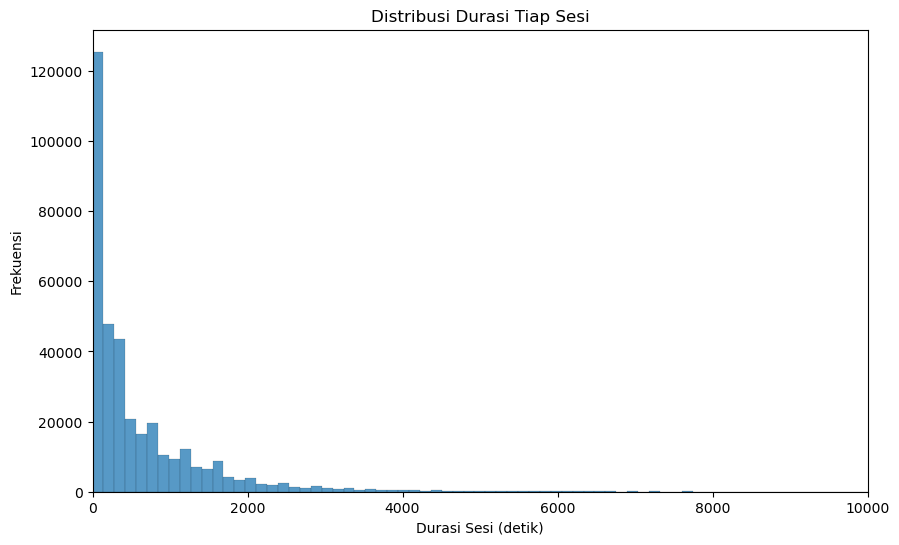

In [26]:
# Menghitung durasi tiap sesi
visits['sess_dura_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
session_per_sec = visits['sess_dura_sec'].mean()

# Menampilkan histogram distribusi durasi tiap sesi
plt.figure(figsize=(10, 6))
sns.histplot(visits['sess_dura_sec'],bins=600)
plt.xlabel('Durasi Sesi (detik)')
plt.ylabel('Frekuensi')
plt.title('Distribusi Durasi Tiap Sesi')
plt.xlim(0,10000)
plt.show()

In [27]:
# Menampilkan rata-rata durasi tiap sesi
round(session_per_sec/60,2)

10.73

Untuk rata-rata durasi tiap sesi dapat diketahui yaitu sekitar 10 menit. 

#### Sticky Factor

In [28]:
# Menghitung sticky factor
sticky_wau = round((dau / wau) * 100, 2).astype(str)+'%'
sticky_mau = round((dau / mau) * 100, 2).astype(str)+'%'

In [29]:
# Menampilkan Hasilnya
sticky_wau, sticky_mau

(user_id    15.59%
 dtype: object,
 user_id    3.91%
 dtype: object)

Hasilnya yaitu:
- Sticky factor harian (sticky_wau) sekitar 15.59%.
- Sticky factor bulanan (sticky_mau) sekitar 3.91%.

**Kesimpulan Analisis Produk**
1. Dari hasil di atas telah didapatkan hasil rata-rata jumlah pengguna yang aktif secara berturut-turut yaitu:
    - Pengguna aktif harian berjumlah 907 pelanggan.
    - Pengguna aktif mingguan berjumlah 5825 pelanggan.
    - Pengguna aktif bulanan berjumlah 23228 pelanggan.
2. Secara rata-rata, jumlah sesi kunjungan tiap harinya yaitu sebanyak 987 sesi.
3. Untuk rata-rata durasi tiap sesi dapat diketahui yaitu sekitar 10 menit.
4. 15.59% konsumen harian menggunakan produk berulang tiap minggu, dan 3.91% konsumen harian menggunakan produk berulang tiap bulan.

### Analisis Penjualan
Analisis ini menggunakan metrik-metrik sebagai berikut:
- Waktu dimulainya pelanggan melakukan pembelian.
- Jumlah pesanan dalam periode tertentu.
- Rata-rata pembelian.
- Lifetime Value / siklus hidup pelanggan.

#### Waktu Pelanggan Melakukan Pembelian

In [30]:
# Membuat tabel waktu registrasi pelanggan
first_reg = visits.groupby('user_id').agg({'start_ts':'min'}).reset_index()
first_reg.columns = ['user_id', 'reg_date']
first_reg.name = 'first_reg'
first_reg.head()

,user_id,reg_date
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


In [31]:
# Membuat tabel pemesanan pertama
first_orders = orders.groupby('user_id')['order_ts'].min().reset_index()
first_orders.columns = ['user_id', 'first_order']
first_orders.name = 'first_orders'
first_orders.head()

,user_id,first_order
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00


In [32]:
# Menggabungkan tabel pelanggan melakukan registrasi dengan tabel pemesanan pertama pelanggan
visit_order = pd.merge(first_reg,first_orders, on='user_id')

# Menghitung waktu pelanggan melakukan pembelian
visit_order['buy_time_lag'] = (visit_order['first_order'] - visit_order['reg_date']).astype('timedelta64[m]')
visit_order[['buy_time_lag']].describe()

,buy_time_lag
count,36523.000000
mean,24340.175834
std,67784.774690
min,0.000000
25%,4.000000
50%,16.000000
75%,2897.000000
max,523144.000000


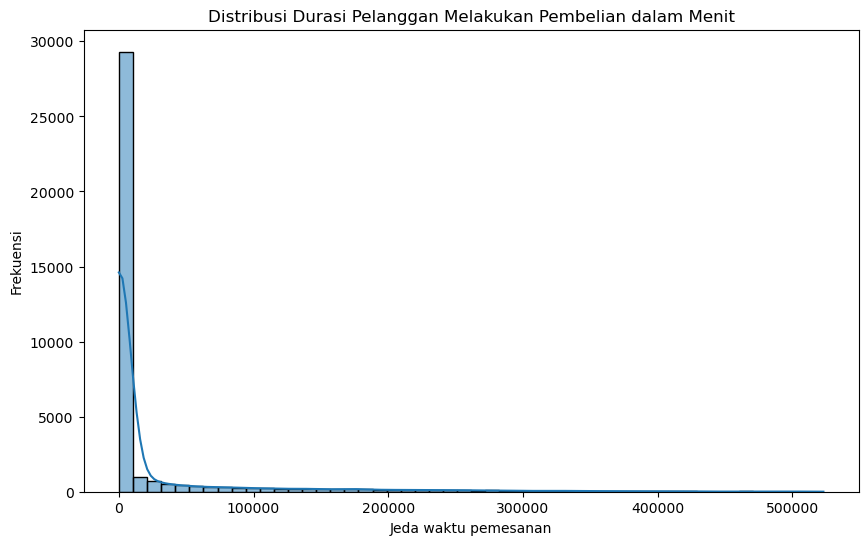

In [33]:
# Menampilkan histogram distribusi durasi menit
plt.figure(figsize=(10, 6))
sns.histplot(visit_order['buy_time_lag'],bins=50,kde=True)
plt.xlabel('Jeda waktu pemesanan')
plt.ylabel('Frekuensi')
plt.title('Distribusi Durasi Pelanggan Melakukan Pembelian dalam Menit')
plt.show()

In [34]:
# Menampilkan hasil dalam format yang sesuai 
'''
min_dura = visit_order['buy_time_lag'].min().astype('timedelta64[m]')
max_dura = visit_order['buy_time_lag'].max().astype('timedelta64[m]')
avg_dura = visit_order['buy_time_lag'].mean().astype('timedelta64[m]')
med_dura = visit_order['buy_time_lag'].median().astype('timedelta64[m]')

def format_durasi(durasi):
    if durasi < timedelta(hours=1):
        return f"{durasi.astype('timedelta64[m]')}"
    elif durasi < timedelta(days=1):
        return f"{durasi.astype('timedelta64[h]')} / {durasi.astype('timedelta64[m]')}"
    elif durasi < timedelta(weeks=1):
        return f"{durasi.astype('timedelta64[D]')} / {durasi.astype('timedelta64[h]')}"
    elif durasi < timedelta(weeks=4):
        return f"{durasi.astype('timedelta64[W]')} / {durasi.astype('timedelta64[D]')}"
    else:
        return f"{durasi.astype('timedelta64[M]')} / {durasi.astype('timedelta64[D]')}"
    
min_data = format_durasi(min_dura)
max_data = format_durasi(max_dura)
mean_data = format_durasi(avg_dura)
med_data = format_durasi(med_dura)

print(f"Durasi tercepat  : {min_data}")
print(f"Durasi terlama   : {max_data}")
print(f"Rata-rata durasi : {mean_data}")
print(f"Median durasi    : {med_data}")
print(f"Modus durasi     : {mode(visit_order['buy_time_lag'])}")

'''

def format_durasi(durasi_menit):
    durasi = timedelta(minutes=durasi_menit)
    
    # Konversi ke jumlah hari
    total_days = int(durasi.total_seconds() // 86400)

    # Hitung jumlah bulan dan sisa hari
    months = total_days // 30  # Anggap 1 bulan = 30 hari
    remaining_days = total_days % 30

    if durasi < timedelta(hours=1):
        return f"{int(durasi.total_seconds() // 60)} minutes"
    elif durasi < timedelta(days=1):
        return f"{int(durasi.total_seconds() // 3600)} hours / {int(durasi.total_seconds() // 60)} minutes"
    elif durasi < timedelta(weeks=1):
        return f"{total_days} days / {int(durasi.total_seconds() // 3600)} hours"
    elif durasi < timedelta(weeks=4):
        return f"{total_days // 7} weeks / {total_days} days"
    else:
        return f"{months} months / {total_days} days"
    
# Konversi buy_time_lag ke menit
min_dura = visit_order['buy_time_lag'].min()
max_dura = visit_order['buy_time_lag'].max()
avg_dura = visit_order['buy_time_lag'].mean()
med_dura = visit_order['buy_time_lag'].median()

# Format hasil dengan fungsi baru
min_data = format_durasi(min_dura)
max_data = format_durasi(max_dura)
mean_data = format_durasi(avg_dura)
med_data = format_durasi(med_dura)

print(f"Durasi tercepat  : {min_data}")
print(f"Durasi terlama   : {max_data}")
print(f"Rata-rata durasi : {mean_data}")
print(f"Median durasi    : {med_data}")
print(f"Modus durasi     : {mode(visit_order['buy_time_lag'])}")

Durasi tercepat  : 0 minutes
Durasi terlama   : 12 months / 363 days
Rata-rata durasi : 2 weeks / 16 days
Median durasi    : 16 minutes
Modus durasi     : 1.0


Berdasarkan analisis di atas, waktu yang dibutuhkan pelanggan untuk memutuskan melakukan pembelian yaitu:
- Pelanggan yang paling cepat melakukan pembelian setelah pendaftaran yaitu 0 menit setelah pelanggan melakukan pendaftaran.
- Paling lama yaitu selama 363 hari atau sekitar 11 bulan setelah pelanggan melakukan pendaftaran.
- Rata-rata pelanggan melakukan pembelian setelah pendaftaran yaitu selama 16 hari atau sekitar 2 minggu 
- Median pelanggan melakukan pembelian setelah pendaftaran yaitu sekitar 16 menit.
- Kebanyakan pelanggan melakukan pembelian setelah pendaftaran yaitu sekitar 1 menit

#### Jumlah Pesanan Dalam Periode Tertentu

In [35]:
# Membuat tabel cohort pembelian 
cohort_order = first_orders.merge(orders, on='user_id')
cohort_order['first_order_month'] = cohort_order['first_order'].astype('datetime64[M]')
cohort_order['order_ts_month'] = cohort_order['order_ts'].astype('datetime64[M]')
cohort_order['cohort_lifetime'] = (cohort_order['order_ts_month'] - cohort_order['first_order_month'])/ np.timedelta64(1, 'M')

# Mengganti tipe data untuk memperbaiki hasil tampilannya
cohort_order['cohort_lifetime'] = cohort_order['cohort_lifetime'].round().astype(int)
cohort_order['first_order_month'] = cohort_order['first_order_month'].dt.strftime('%Y-%m') 
cohort_order.head()

,user_id,first_order,order_ts,revenue,first_order_month,order_ts_month,cohort_lifetime
0,313578113262317,2018-01-03 21:51:00,2018-01-03 21:51:00,0.55,2018-01,2018-01-03 21:51:00,0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,1.22,2017-06,2017-06-03 10:13:00,0
2,1575281904278712,2017-06-03 10:13:00,2017-06-03 17:39:00,1.83,2017-06,2017-06-03 17:39:00,0
3,2429014661409475,2017-10-11 18:33:00,2017-10-11 18:33:00,73.33,2017-10,2017-10-11 18:33:00,0
4,2464366381792757,2018-01-28 15:54:00,2018-01-28 15:54:00,2.44,2018-01,2018-01-28 15:54:00,0


In [36]:
# Menggabungkan tabel first_orders dengan orders berdasarkan 'user_id'
cohort_order = first_orders.merge(orders, on='user_id')

# Konversi tanggal menjadi format datetime
cohort_order['first_order_month'] = cohort_order['first_order'].dt.to_period('M')
cohort_order['order_ts_month'] = cohort_order['order_ts'].dt.to_period('M')

# Menghitung selisih bulan dengan relativedelta agar hasil lebih akurat
def get_month_diff(row):
    return (row['order_ts_month'].year - row['first_order_month'].year) * 12 + \
           (row['order_ts_month'].month - row['first_order_month'].month)

cohort_order['cohort_lifetime'] = cohort_order.apply(get_month_diff, axis=1)

# Mengubah format first_order_month agar lebih bersih
cohort_order['first_order_month'] = cohort_order['first_order_month'].astype(str)
cohort_order.head()

,user_id,first_order,order_ts,revenue,first_order_month,order_ts_month,cohort_lifetime
0,313578113262317,2018-01-03 21:51:00,2018-01-03 21:51:00,0.55,2018-01,2018-01,0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,1.22,2017-06,2017-06,0
2,1575281904278712,2017-06-03 10:13:00,2017-06-03 17:39:00,1.83,2017-06,2017-06,0
3,2429014661409475,2017-10-11 18:33:00,2017-10-11 18:33:00,73.33,2017-10,2017-10,0
4,2464366381792757,2018-01-28 15:54:00,2018-01-28 15:54:00,2.44,2018-01,2018-01,0


In [37]:
# Membuat pivot_table cohort pemesanan
order_pivot = cohort_order.pivot_table(
    index='first_order_month',
    columns='cohort_lifetime',
    values='user_id',
    aggfunc='count',
)
order_pivot.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,2354.0,177.0,174.0,226.0,292.0,218.0,276.0,174.0,212.0,153.0,96.0,86.0
2017-07,2186.0,100.0,120.0,104.0,72.0,82.0,61.0,50.0,58.0,24.0,53.0,
2017-08,1533.0,108.0,100.0,81.0,85.0,62.0,49.0,78.0,46.0,46.0,,
2017-09,2933.0,219.0,161.0,164.0,67.0,109.0,108.0,56.0,61.0,,,
2017-10,4964.0,314.0,162.0,122.0,129.0,103.0,86.0,125.0,,,,
2017-11,4813.0,397.0,182.0,211.0,136.0,59.0,102.0,,,,,
2017-12,5052.0,270.0,202.0,179.0,86.0,105.0,,,,,,
2018-01,3783.0,224.0,159.0,64.0,78.0,,,,,,,
2018-02,4095.0,222.0,83.0,70.0,,,,,,,,


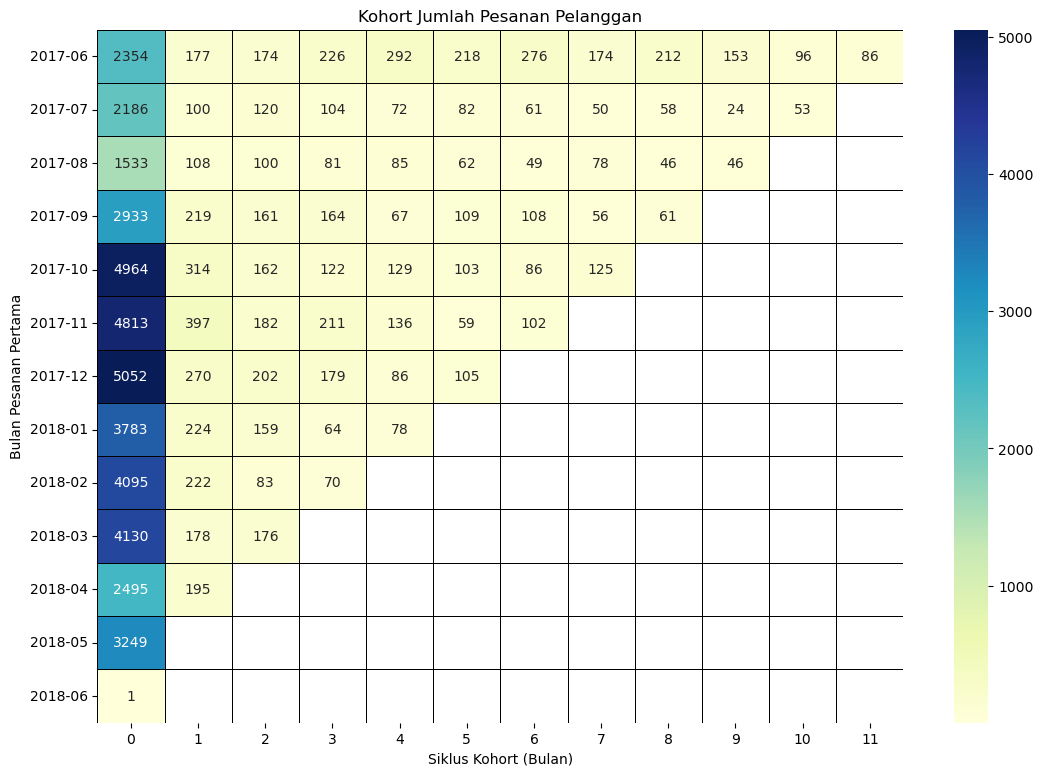

In [38]:
# Menampilkan pivot_table cohort pemesanan dengan heatmap
plt.figure(figsize=(13, 9))
plt.title('Kohort Jumlah Pesanan Pelanggan')
sns.heatmap(
    order_pivot,
    annot=True,
    fmt='g',
    linewidths=0.5,
    linecolor='black',
    cmap='YlGnBu'
)
plt.xlabel('Siklus Kohort (Bulan)')
plt.ylabel('Bulan Pesanan Pertama')
plt.show()

Pada heatmap di atas dapat ditarik kesimpulan yaitu jumlah pesanan meningkat dari bulan September tahun 2017 sampai puncaknya pada bulan Desember tahun 2017 sebanyak 5052 pesanan. Hal ini terjadi karena banyak pelanggan yang ingin menggunakan produk Y.Afisha pada akhir tahun. Akan tetapi, jumlah pesanan pelanggan dari awal pembelian semakin lama semakin menurun. Departemen Pemasaran perlu memikirkan strategi supaya jumlah pesanan pada bulan berikutnya untuk setiap pelanggan meningkat atau tetap bertahan.

#### Rata-rata pembelian.

In [39]:
# Mengelompokkan tabel pembelian
orders_group_cohort = cohort_order.groupby(
                                ['first_order_month', 'cohort_lifetime']).agg(
                                {'revenue': 'sum', 'user_id': 'nunique'})
orders_group_cohort['rev_per_user'] = orders_group_cohort['revenue'] / orders_group_cohort['user_id']
orders_group_cohort.columns = ['sum_revenue', 'count_users', 'revenue_per_user']
orders_group_cohort.head()

sum_revenue  count_users  revenue_per_user
first_order_month cohort_lifetime                                            
2017-06           0                    9557.49         2023          4.724414
                  1                     981.82           61         16.095410
                  2                     885.34           50         17.706800
                  3                    1931.30           54         35.764815
                  4                    2068.58           88         23.506591

In [40]:
# Membuat pivot_table dari rata-rata pembelian
revenue_pivot = orders_group_cohort.pivot_table(
    index='first_order_month',
    columns='cohort_lifetime',
    values='revenue_per_user',
    aggfunc='mean',
) 
revenue_pivot.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.724414,16.09541,17.7068,35.764815,23.506591,22.207761,31.011935,25.033191,19.29569,27.233556,25.681333,9.804151
2017-07,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,
2017-08,5.276518,11.148793,11.851321,12.182955,16.92125,12.139062,9.620333,12.610455,21.07,8.307419,,
2017-09,5.644529,22.188385,13.4452,138.669189,19.881538,26.095,27.437121,16.961351,11.044651,,,
2017-10,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,,,,
2017-11,5.154683,7.339054,6.786583,12.51066,7.457284,4.580833,7.564839,,,,,
2017-12,4.738191,7.816575,39.366019,48.135052,27.4314,23.518413,,,,,,
2018-01,4.135636,8.721228,12.365542,11.199767,4.699556,,,,,,,
2018-02,4.156987,8.61,4.942414,6.941026,,,,,,,,


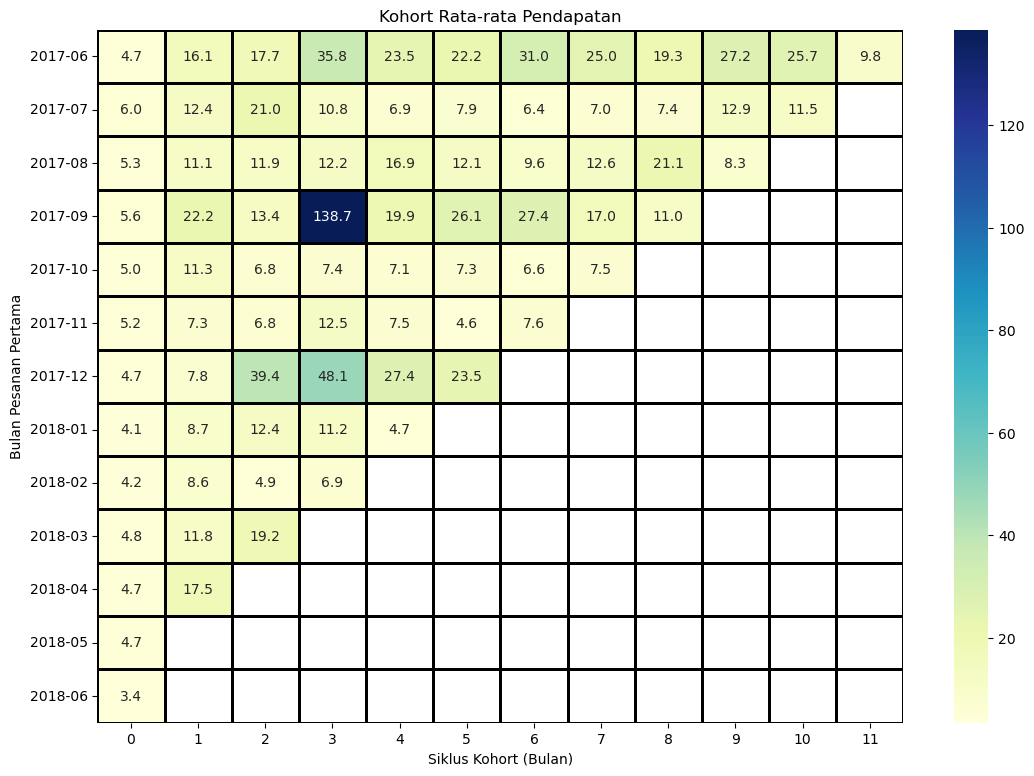

In [41]:
# Menampilkan pivot_table cohort pemesanan dengan heatmap
plt.figure(figsize=(13, 9))
plt.title('Kohort Rata-rata Pendapatan')
sns.heatmap(
    revenue_pivot,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='black',
    cmap='YlGnBu'
)
plt.xlabel('Siklus Kohort (Bulan)')
plt.ylabel('Bulan Pesanan Pertama')
plt.show()

Rata-rata pendapatan tertinggi yaitu pada akhir tahun 2017 pada bulan Desember sebesar 138.7, dimana para pelanggan melakukan awal pembelian pada bulan September. Hal ini menunjukkan bahwa banyak pelanggan dari bulan September yang melakukan pembelian di bulan Desember membawa keuntungan yang berkali-kali lipat dari awal pembelian. Tim pemasaran perlu mempersiapkan strategi berikutnya supaya memaksimalkan pendapatan di akhir tahun mendatang.

#### Jumlah Pendapatan LTV

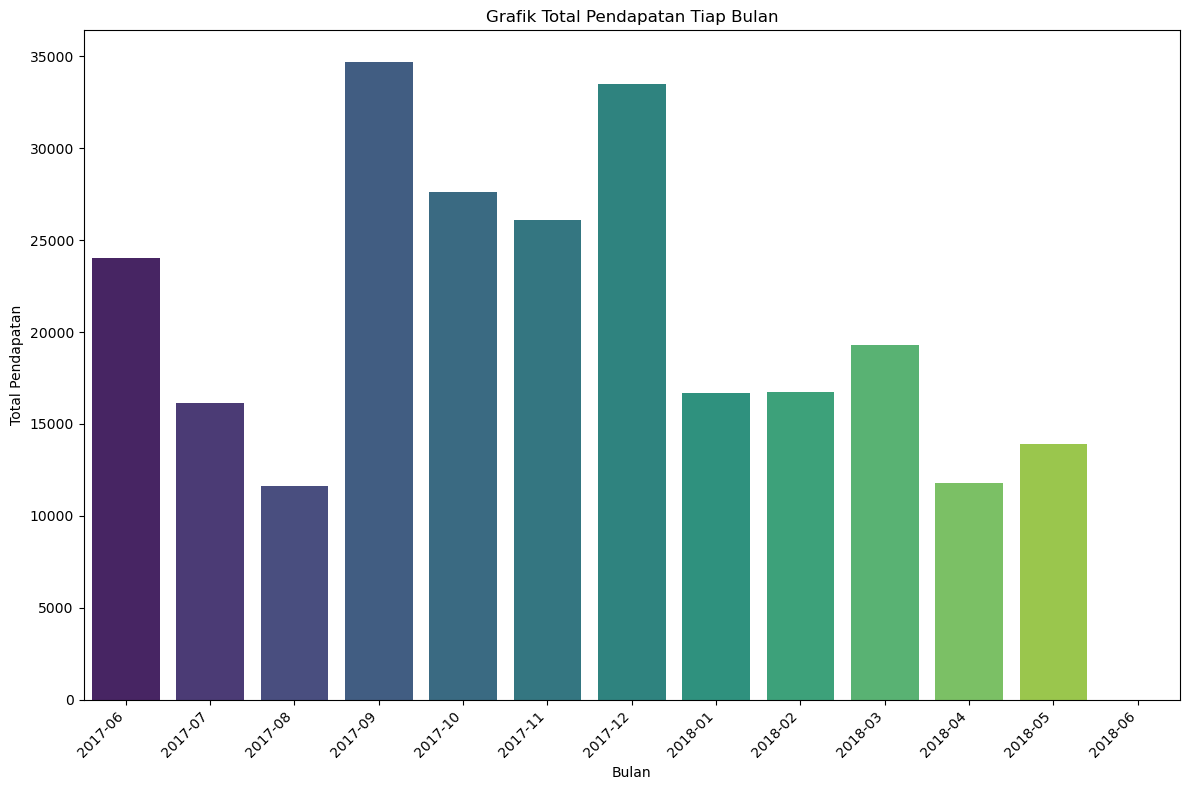

,first_order_month,revenue
0,2017-06,24031.69
1,2017-07,16127.92
2,2017-08,11606.26
3,2017-09,34676.32
4,2017-10,27603.45
5,2017-11,26098.99
6,2017-12,33485.74
7,2018-01,16663.13
8,2018-02,16750.50
9,2018-03,19273.41


In [42]:
cohort_revenue = cohort_order.groupby([
    'first_order_month', 'order_ts_month','cohort_lifetime']).agg({'revenue':'sum'}).reset_index()

revenue_sum = cohort_revenue.pivot_table(index='first_order_month', values='revenue', aggfunc='sum').reset_index()

# Menampilkan total pendapatan tiap bulan dengan grafik batang
plt.figure(figsize=(12, 8))
sns.barplot(data=revenue_sum, x='first_order_month', y='revenue', palette='viridis')
plt.xlabel('Bulan')
plt.ylabel('Total Pendapatan')
plt.title('Grafik Total Pendapatan Tiap Bulan')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

revenue_sum

In [43]:
# Menghitung total pendapatan
revenue_sum['revenue'].sum().round(2)

252057.2

Dari data di atas, dapat ditarik kesimpulan yaitu:
- Pendapatan tertinggi terjadi pada September 2017 dengan total pendapatan sebanyak 34676.32 dan pendapatan tertinggi kedua diikuti pada bulan Desember 2017 dengan pendapatan sebesar 33485.74
- Total pendapatan dari para pelanggan selama 1 tahun yaitu sekitar 252057.2

In [44]:
# Membuat tabel jumlah pengguna
cohort_users = cohort_order.groupby('first_order_month').agg({'user_id':'nunique'}).reset_index()
cohort_users.columns = ['first_order_month', 'users']

# Menggabungkan tabel cohort_revenue dengan tabel cohort_users
report = cohort_users.merge(cohort_revenue, on='first_order_month')
report['ltv'] = report['revenue'] / report['users']

# Membuat tabel pivot LTV
report_ltv = report.pivot_table(index='first_order_month', columns='cohort_lifetime', values='ltv', aggfunc='mean').round(2)
report_ltv.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,
2017-08,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,,
2017-09,5.64,1.12,0.52,3.98,0.4,0.65,0.7,0.24,0.18,,,
2017-10,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,,,,
2017-11,5.15,0.4,0.2,0.32,0.15,0.05,0.11,,,,,
2017-12,4.74,0.26,0.93,1.07,0.31,0.34,,,,,,
2018-01,4.14,0.29,0.3,0.14,0.06,,,,,,,
2018-02,4.16,0.28,0.08,0.07,,,,,,,,


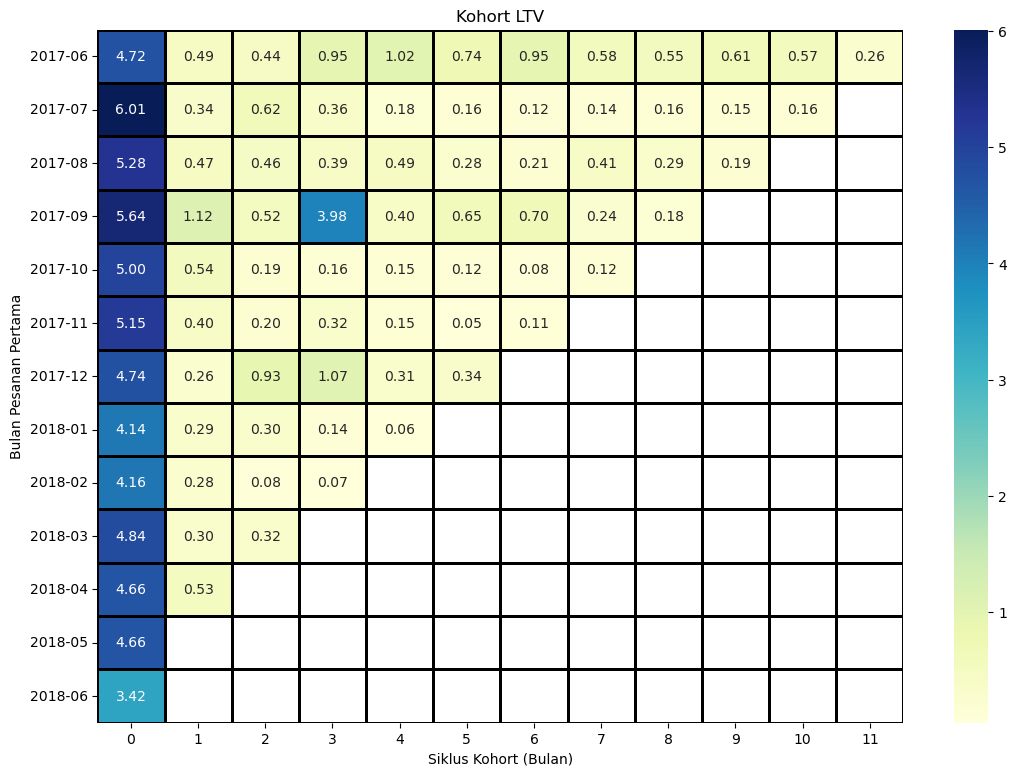

In [45]:
# Menampilkan pivot_table ltv dengan heatmap
plt.figure(figsize=(13, 9))
plt.title('Kohort LTV')
sns.heatmap(
    report_ltv,
    annot=True,
    fmt='.2f',
    linewidths=1,
    linecolor='black',
    cmap='YlGnBu'
)
plt.xlabel('Siklus Kohort (Bulan)')
plt.ylabel('Bulan Pesanan Pertama')
plt.show()

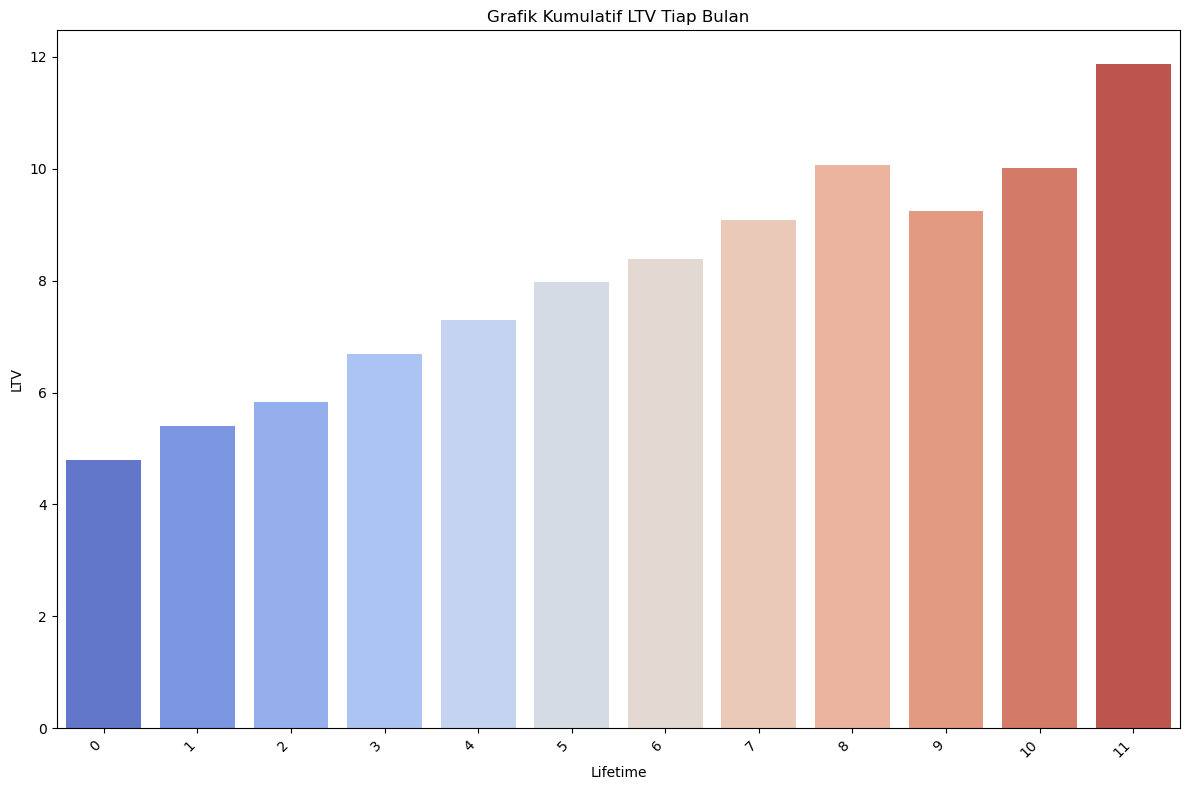

In [46]:
cum_report_ltv = report_ltv.cumsum(axis=1).mean(axis=0).reset_index()
cum_report_ltv.columns = ['cohort_lifetime', 'cumulative_LTV']
cum_report_ltv

# Menampilkan total pendapatan tiap bulan dengan grafik batang
plt.figure(figsize=(12, 8))
sns.barplot(data=cum_report_ltv, x='cohort_lifetime', y='cumulative_LTV', palette='coolwarm')
plt.xlabel('Lifetime')
plt.ylabel('LTV')
plt.title('Grafik Kumulatif LTV Tiap Bulan')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

LTV pelanggan tiap bulan rata-rata menurun semenjak bulan pertama pembelian. Tetapi para pelanggan yang melakukan pembelian pertama di bulan September mengalami kenaikan yang signifikan pada usia 4 bulan yakni pada akhir tahun 2017 bulan Desember. Selain itu, LTV kumulatif pada grafik di atas menunjukkan bahwa nilai LTV mengalami kenaikan secara konsisten.

**Kesimpulan Penjualan**
1. Pelanggan yang paling cepat melakukan pembelian setelah pendaftaran yaitu 0 menit setelah pelanggan melakukan pendaftaran dan paling lama yaitu selama 363 hari atau sekitar 11 bulan. Rata-rata pelanggan melakukan pembelian setelah pendaftaran yaitu selama 16 hari atau sekitar 2 minggu dan mediannya sekitar 16 menit. Akan tetapi, kebanyakan pelanggan melakukan pembelian setelah pendaftaran yaitu sekitar 1 menit
2. Jumlah pesanan meningkat secara siginifikan dari bulan September tahun 2017 sampai puncaknya pada bulan Desember tahun 2017 sebanyak 5052 pesanan. 
3. Rata-rata pendapatan tertinggi yaitu pada akhir tahun 2017 pada bulan Desember dimana para pelanggan melakukan awal pembelian pada bulan September. 
4. Sedangkan untuk pembelian tertinggi terjadi pada September 2017 dengan total pendapatan sebanyak 34676.32 dan pendapatan tertinggi kedua diikuti pada bulan Desember 2017 dengan pendapatan sebesar 33485.74 Total pendapatan dari para pelanggan selama 1 tahun yaitu sekitar 252057.2.
5. LTV pelanggan tiap bulan rata-rata menurun semenjak bulan pertama pembelian. Tetapi para pelanggan yang melakukan pembelian pertama di bulan September mengalami kenaikan yang signifikan pada usia 4 bulan yakni pada akhir tahun 2017 bulan Desember. Selain itu, LTV kumulatif pada grafik di atas menunjukkan bahwa nilai LTV mengalami kenaikan secara konsisten.

### Analisis Pemasaran
Analisi ini menggunakan metrik-metrik sebagai berikut:
- Jumlah Biaya (Keseluruhan/per sumber/dari waktu ke waktu)
- Biaya CAC Tiap Sumber
- ROMI / Titik Impas Bisnis

#### Jumlah Biaya (Keseluruhan/per sumber/dari waktu ke waktu)

In [47]:
# Menghitung jumlah biaya secara keseluruhan
costs['costs'].sum()

329131.62

Jumlah biaya yang dikeluarkan oleh tim pemasaran sebesar USD 321,131.62 

In [48]:
# Menghitung jumlah biaya tiap sumber
source_cost = costs.groupby('source_id').agg({'costs':'sum'}).reset_index()
source_cost['percent %'] = ((source_cost['costs'] / source_cost['costs'].sum()) * 100).round(2).astype(str)+('%')
source_cost = source_cost.sort_values(by='costs', ascending=False)
source_cost

,source_id,costs,percent %
2,3,141321.63,42.94%
3,4,61073.60,18.56%
4,5,51757.10,15.73%
1,2,42806.04,13.01%
0,1,20833.27,6.33%
6,10,5822.49,1.77%
5,9,5517.49,1.68%


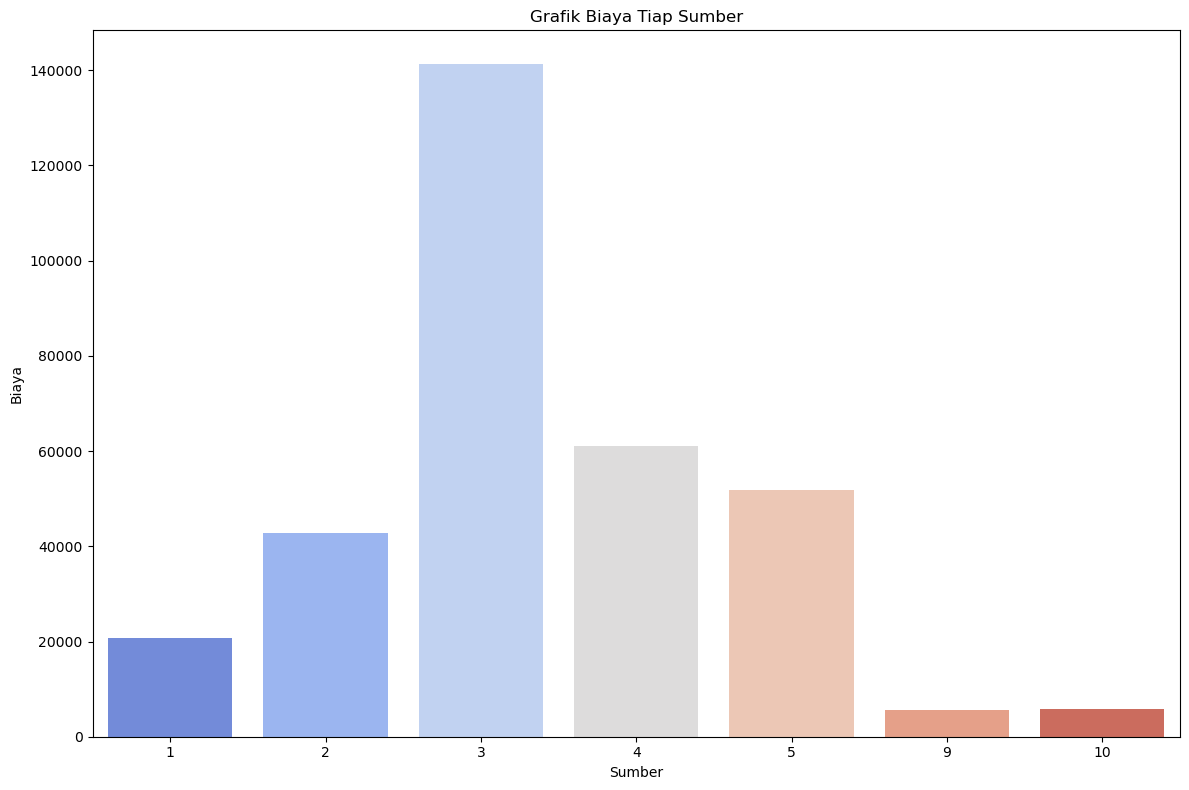

In [49]:
# Menampilkan biaya tiap sumber dengan grafik
plt.figure(figsize=(12, 8))
sns.barplot(data=source_cost, x='source_id', y='costs', palette='coolwarm')
plt.xlabel('Sumber')
plt.ylabel('Biaya')
plt.title('Grafik Biaya Tiap Sumber')
plt.tight_layout()
plt.show()

Biaya pemasaran tertinggi dikerahkan untuk sumber 3 sebanyak USD 141,321.63 atau sekitar 42.94% dari total biaya pemasaran. Sedangkan biaya pemasaran terendah pada sumber 9 dengan biaya USD 5,517.49 atau sekitar 1.68%. Diikuti oleh sumber 10 dengan biaya USD 5,822.49 atau sekitar 1.77%.

In [50]:
# Menghitung biaya tiap bulan
costs['date'] = pd.to_datetime(costs['date'])
costs['month'] = costs['date'].dt.to_period('M')  # Lebih stabil daripada astype('datetime64[M]')
monthly_costs = costs.groupby('month').agg({'costs': 'sum'}).reset_index()
monthly_costs['month'] = monthly_costs['month'].dt.to_timestamp().dt.strftime('%Y-%m')
monthly_costs

,month,costs
0,2017-06,18015.00
1,2017-07,18240.59
2,2017-08,14790.54
3,2017-09,24368.91
4,2017-10,36322.88
5,2017-11,37907.88
6,2017-12,38315.35
7,2018-01,33518.52
8,2018-02,32723.03
9,2018-03,30415.27


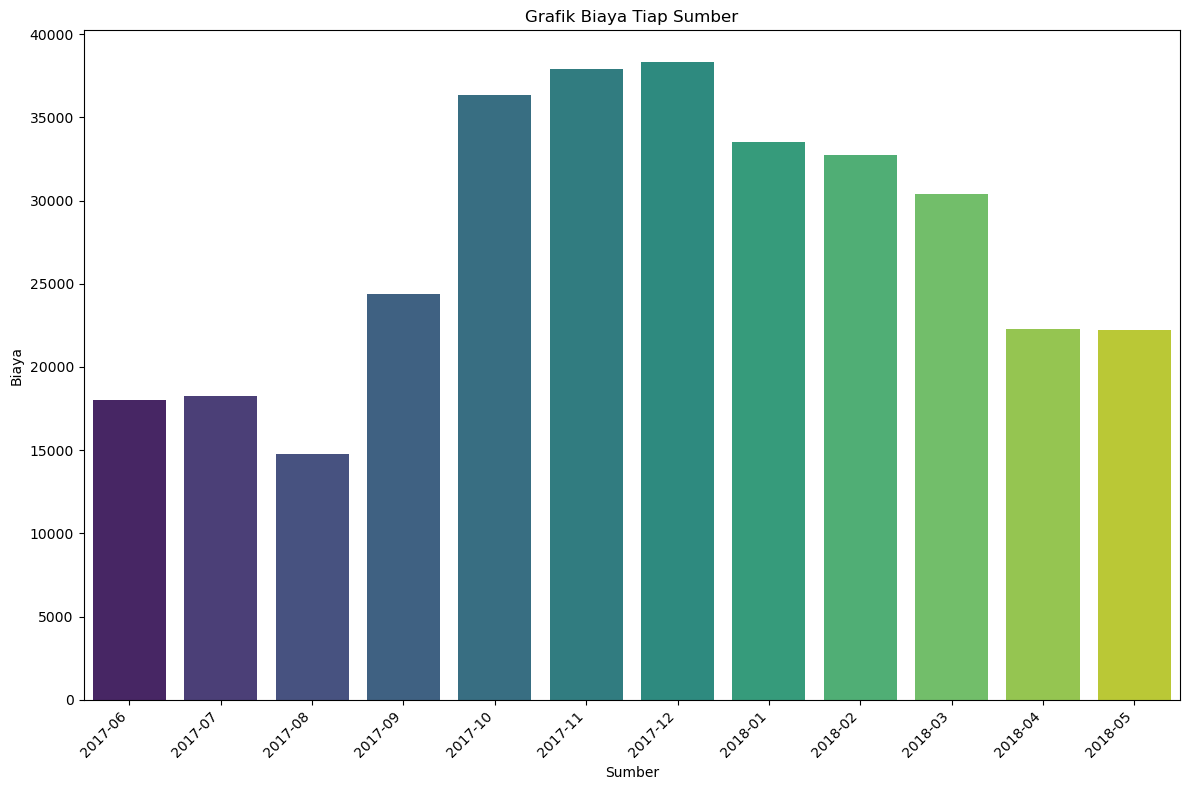

In [51]:
# Menampilkan biaya tiap bulan dengan grafik
plt.figure(figsize=(12, 8))
sns.barplot(data=monthly_costs, x='month', y='costs', palette='viridis')
plt.xlabel('Sumber')
plt.ylabel('Biaya')
plt.title('Grafik Biaya Tiap Sumber')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Biaya pemasaran meningkat ketika menjelang akhir tahun dan menurun di awal tahun. Biaya meningkat dimulai dari bulan September hingga puncaknya pada bulan Desember dengan biaya pemasaran tertinggi sebesar USD 38,315.35. 

#### CAC / Customer Acquisition Cost

In [52]:
# Mengelompokkan source_id dengan jumlah users
cohort_size = visits.groupby('source_id').agg({'user_id':'nunique'}).reset_index()
cohort_size.columns = ['source_id','users']
cohort_size

,source_id,users
0,1,18999
1,2,26245
2,3,74756
3,4,83525
4,5,56974
5,6,6
6,7,34
7,9,9264
8,10,8067


In [53]:
# Membuat tabel cac
report_cac = cohort_size.merge(source_cost, how='outer', on='source_id')
report_cac['cac'] = (report_cac['costs'] / report_cac['users']).round(2)
report_cac

,source_id,users,costs,percent %,cac
0,1,18999,20833.27,6.33%,1.10
1,2,26245,42806.04,13.01%,1.63
2,3,74756,141321.63,42.94%,1.89
3,4,83525,61073.60,18.56%,0.73
4,5,56974,51757.10,15.73%,0.91
5,6,6,NaN,NaN,NaN
6,7,34,NaN,NaN,NaN
7,9,9264,5517.49,1.68%,0.60
8,10,8067,5822.49,1.77%,0.72


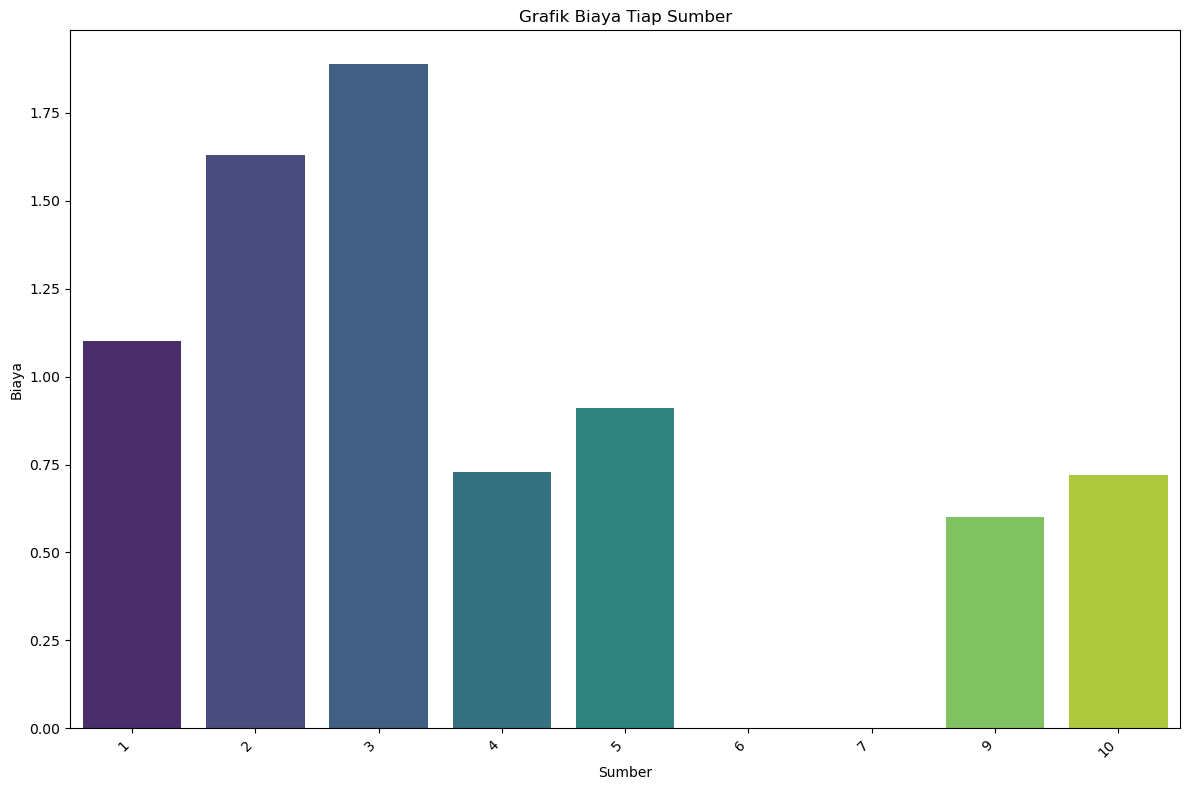

In [54]:
# Menampilkan grafik cac
plt.figure(figsize=(12, 8))
sns.barplot(data=report_cac, x='source_id', y='cac', palette='viridis')
plt.xlabel('Sumber')
plt.ylabel('Biaya')
plt.title('Grafik Biaya Tiap Sumber')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Sumber 3 memiliki CAC tertinggi yaitu sekitar 1.89, hal ini menunjukkan biaya yang dikerahkan tidak terlalu efektif dalam menarik calon konsumen. Sementara itu, sumber 7 memiliki CAC terendah, sehingga biaya yang sudah dikerahkan cukup efisien dalam hal menghemat biaya serta menarik calom konsumen.

#### ROMI

In [55]:
# Membuat tabel final_report untuk menghitung romi
final_report = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
final_report['cac'] = (final_report['costs'] / final_report['users']).round(2)
final_report['ltv'] = final_report['ltv'].round(2)
final_report['romi'] = final_report['ltv'] / final_report['cac']
final_report.head()

,first_order_month,users,order_ts_month,cohort_lifetime,revenue,ltv,month,costs,cac,romi
0,2017-06,2023,2017-06,0,9557.49,4.72,2017-06,18015.0,8.91,0.529742
1,2017-06,2023,2017-07,1,981.82,0.49,2017-06,18015.0,8.91,0.054994
2,2017-06,2023,2017-08,2,885.34,0.44,2017-06,18015.0,8.91,0.049383
3,2017-06,2023,2017-09,3,1931.30,0.95,2017-06,18015.0,8.91,0.106622
4,2017-06,2023,2017-10,4,2068.58,1.02,2017-06,18015.0,8.91,0.114478


In [56]:
# membuat pivot table untuk menampilkan nilai kumulatif romi
output_final = final_report.pivot_table(index='month', columns='cohort_lifetime', values='romi', aggfunc='mean')
cum_output_final = output_final.cumsum(axis=1).round(2) 
cum_output_final.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
month,,,,,,,,,,,,
2017-06,0.53,0.58,0.63,0.74,0.86,0.94,1.04,1.11,1.17,1.24,1.3,1.33
2017-07,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.89,
2017-08,0.49,0.53,0.58,0.61,0.66,0.68,0.7,0.74,0.77,0.78,,
2017-09,0.60,0.72,0.77,1.19,1.24,1.3,1.38,1.4,1.42,,,
2017-10,0.60,0.66,0.68,0.7,0.72,0.74,0.75,0.76,,,,
2017-11,0.55,0.6,0.62,0.65,0.67,0.67,0.69,,,,,
2017-12,0.54,0.57,0.68,0.8,0.84,0.88,,,,,,
2018-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02,0.46,0.5,0.5,0.51,,,,,,,,


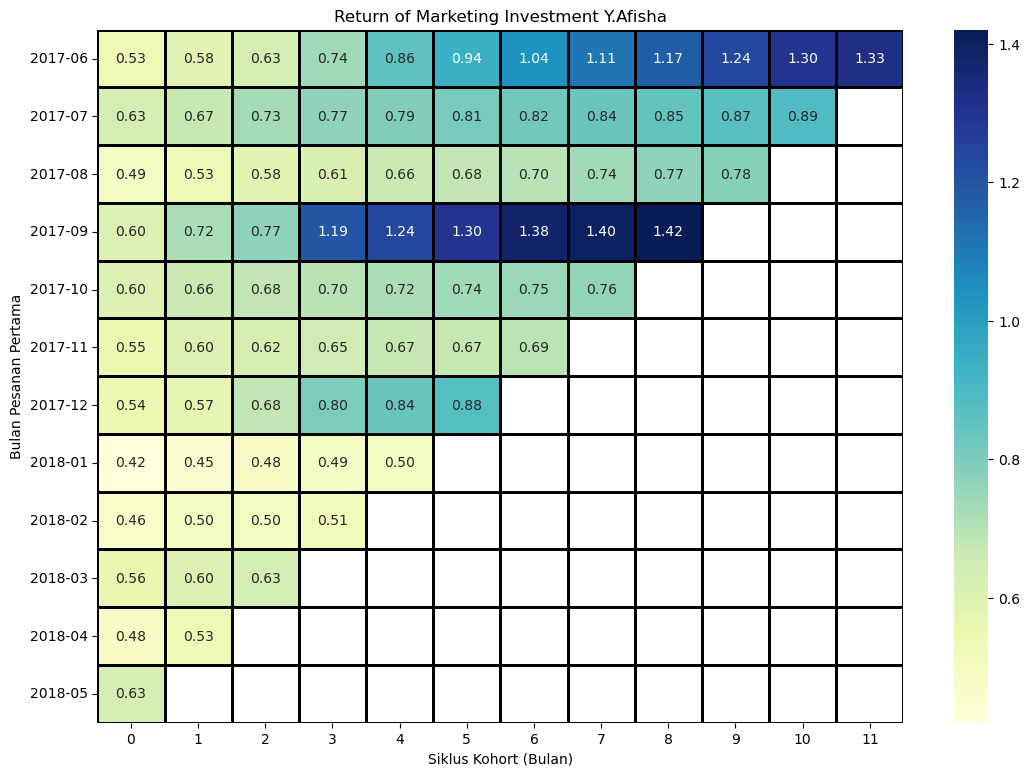

In [57]:
# Menampilkan output_final romi dengan heatmap
plt.figure(figsize=(13, 9))
plt.title('Return of Marketing Investment Y.Afisha')
sns.heatmap(
    cum_output_final,
    annot=True,
    fmt='.2f',
    linewidths=1,
    linecolor='black',
    cmap='YlGnBu'
)
plt.xlabel('Siklus Kohort (Bulan)')
plt.ylabel('Bulan Pesanan Pertama')
plt.show()

Pada heatmap di atas dapat ditarik kesimpulan yaitu:
- Kohort bulan Juni baru bisa menutupi biaya pemasaran pada bulan ke-6 setelah pembelian pertama yaitu bulan Desember.
- Kohort bulan September merupakan kohort tercepat dalam hal menutupi biaya pemasaran pada bulan ke-4 yakni di bulan Desember.
- ROMI cenderung meningkat seiring berjalannya waktu, yang menunjukkan bahwa investasi pemasaran mungkin menjadi lebih efektif dalam menghasilkan pendapatan dari kohort pelanggan yang lebih lama.

Hal ini masih belum lengkap untuk melakukan keputusan bisnis. Untuk itu, perlu dihitungnya nilai kumulatif ROMI tiap kohort.

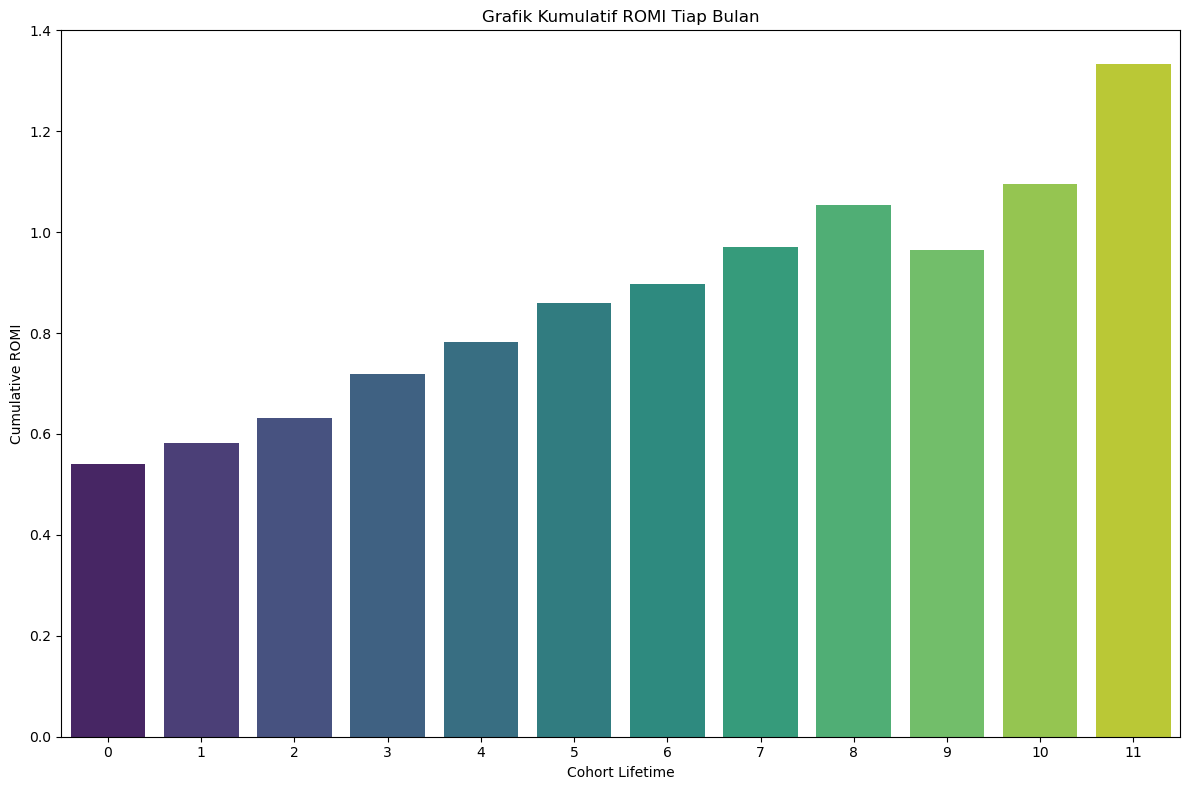

,cohort_lifetime,cum_romi
0,0,0.540726
1,1,0.582007
2,2,0.631125
3,3,0.719696
4,4,0.782719
5,5,0.859870
6,6,0.896344
7,7,0.969776
8,8,1.053382
9,9,0.964240


In [58]:
cum_romi = output_final.cumsum(axis=1).mean(axis=0).reset_index()
cum_romi.columns = ['cohort_lifetime', 'cum_romi']
# Menampilkan kumulatif romi dengan grafik batang
plt.figure(figsize=(12, 8))
sns.barplot(data=cum_romi, x='cohort_lifetime', y='cum_romi', palette='viridis')
plt.xlabel('Cohort Lifetime')
plt.ylabel('Cumulative ROMI')
plt.title('Grafik Kumulatif ROMI Tiap Bulan')
plt.tight_layout()
plt.show()
cum_romi

Dari grafik di atas dapat diketahui bahwa:
- Nilai kumulatif ROMI cenderung meningkat seiring dengan meningkatnya siklus kohort. Ini menunjukkan bahwa investasi pemasaran pada siklus kohort yang lebih lama cenderung lebih menguntungkan dalam jangka panjang. Ini bisa disebabkan oleh faktor seperti loyalitas pelanggan, peningkatan pembelian seiring berjalannya waktu, atau efektivitas strategi retensi pelanggan.
- Namun nilai kumulatif ROMI pada siklus kohort awal (siklus 0, 1, dan 2) lebih rendah dibandingkan dengan siklus kohort yang lebih lama. Hal ini mungkin karena biaya awal untuk akuisisi pelanggan baru mungkin lebih tinggi daripada pendapatan yang dihasilkan dalam siklus kohort awal.
- Setelah siklus kohort ke-2, terjadi peningkatan yang cukup signifikan dalam ROMI. Hal ini menunjukkan bahwa pelanggan yang bertahan lebih lama (siklus kohort 3 dan seterusnya) cenderung memberikan kontribusi pendapatan yang lebih besar dibandingkan dengan biaya pemasaran yang dikeluarkan.
- Siklus kohort ke-10 memiliki ROMI yang lebih tinggi daripada siklus kohort sebelumnya (siklus 9). Namun, ROMI-nya masih di bawah 1 (100%). Hal ini menunjukkan bahwa investasi pemasaran pada siklus kohort ini masih perlu dinilai ulang karena belum mencapai tingkat pengembalian yang diharapkan.
- Titik impas terjadi pada siklus kohort ke-8. Jadi dapat disimpulkan bahwa secara rata-rata kohort membutuhkan waktu hingga 8 bulan untuk menutupi biaya pemasaran.

**Kesimpulan analisis pemasaran**
1. Total biaya pemasaran yang dikeluarkan oleh tim pemasaran adalah sekitar USD 321,131.62. Biaya pemasaran paling tinggi ditempatkan pada sumber 3, yang mencapai sekitar 42.94% dari total biaya. Sementara sumber 9 dan 10 merupakan yang paling efisien dengan biaya pemasaran yang jauh lebih rendah.
2. Terdapat tren kenaikan biaya pemasaran menjelang akhir tahun (mulai dari September) dan penurunan di awal tahun (mulai dari Januari). Puncak biaya pemasaran terjadi pada bulan Desember.
3. Sumber 3 memiliki CAC tertinggi, yang menunjukkan bahwa biaya yang dikeluarkan tidak terlalu efektif dalam menarik calon konsumen. Sumber 7 memiliki CAC terendah, yang mengindikasikan efisiensi dalam pengeluaran biaya untuk akuisisi pelanggan.
4. Titik impas terjadi pada siklus kohort ke-8, yang berarti secara rata-rata kohort memerlukan waktu hingga 8 bulan untuk menutupi biaya pemasaran.
5. Analisis ROMI menunjukkan bahwa investasi pemasaran cenderung lebih efektif dalam jangka panjang, terutama pada siklus kohort yang lebih lama. Sehingga siklus kohort awal memiliki ROMI yang lebih rendah, yang mungkin disebabkan oleh biaya awal yang tinggi.
6. Nilai kumulatif ROMI menunjukkan tren positif seiring dengan meningkatnya siklus kohort, menandakan bahwa investasi pemasaran pada siklus kohort yang lebih lama cenderung lebih menguntungkan dalam jangka panjang.

## Rekomendasi Bisnis
Setelah melakukan analisis produk, penjualan, dan pemasaran terdapat beberapa rekomendasi untuk departemen pemasaran yaitu:
1. Realokasi dana pemasaran karena berdasarkan total pengeluaran saat ini (USD 321.131,62), alokasikan sekitar 30-40% dari anggaran pemasaran untuk channel yang terbukti memiliki CAC rendah dan ROMI tinggi. Dengan mengurangi investasi pada sumber iklan 3 meskipun menghasilkan volume pengguna yang besar, namun memiliki CAC tertinggi. Sebaiknya anggaran untuk sumber ikan ini dikurangi atau dievaluasi kembali efektivitasnya. 
2. Menaikkan jumlah investasi pada sumber iklan 4, 5, 9, dan 10 yang memiliki CAC rendah dan memberikan efisiensi biaya tingg   
3. Memfokuskan pada metrik utama yang perlu dipantau yaitu CAC, LTV, ROMI, dan Conversion Rate. Namun, metrik yang perlu difokuskan adalah Return on Marketing Investment (ROMI). Jika ROMI tetap positif dan meningkat seiring berjalannya waktu, imaka strategi pemasaran berjalan dengan baik.
4. Dengan melakukan pemantauan secara berkala atas metrik-metrik ini akan memastikan strategi yang dinamis dan responsif terhadap perubahan performa.
